In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.4 MB/s eta 0:00:00


In [3]:
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split 
from time import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
import pyarrow as pa
from statistics import mean

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [5]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [6]:
!nvidia-smi

Tue May  2 08:02:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
name_dir = ''
name_file_train_sent = 'train_authors_texts.csv' 
name_file_val_sent = 'val_authors_texts.csv' 
name_file_test_sent = 'test_authors_texts.csv'

In [5]:
random_state = 42
test_size = 0.2 #размер тестовой части
val_size = 0.2 #размер валидационной части
max_len = 512 #максимальная длина входной последовательности
decrease_tokens = 100 #количество токеов на которое уменьшается максимальная длина до достижения порогового значения
part_clipped_texts = 0.01 #пороговое значение количества обрезанных текстов
model_name = 'ai-forever/ruBert-large'
num_author = 5

In [6]:
#Training arguments
output_dir='./results_ruBert_large_sber'       
overwrite_output_dir=True  
save_strategy='epoch'
num_train_epochs=5            
per_device_train_batch_size=32  
per_device_eval_batch_size=32  
weight_decay=0.01              
learning_rate=1e-5              
logging_dir='./logs'          
evaluation_strategy='epoch'

# Загрузка корпуса авторских предложений

In [8]:
df_train = pd.read_csv(name_dir+name_file_train_sent, sep='\t')
df_val = pd.read_csv(name_dir+name_file_val_sent, sep='\t')
df_test = pd.read_csv(name_dir+name_file_test_sent, sep='\t')

In [ ]:
df_train

,text,author,label
0,"Его худое лицо выражало благоговение, синие гл...",Александр Проханов,1
1,В первую очередь компания отличается от всех о...,Артемий Лебедев,2
2,Пелись же большею частью песни так называемые ...,Федор Достоевский,4
3,"Он поднял кулак, восторженно и грозно махая им...",Федор Достоевский,4
4,"Единственный сценарий, когда я готов оставить ...",Артемий Лебедев,2
...,...,...,...
9248,"— Нагахан! — крикнул Сардар сквозь ветер, указ...",Александр Проханов,1
9249,"Сейчас можно смело говорить о том, что именно ...",Александр Коваленко,0
9250,"От автора. События, приведённые в публикуемом ...",Александр Проханов,1
9251,Считаю включенный поворотник сигналом минималь...,Артемий Лебедев,2


In [ ]:
df_val

,text,author,label
0,"В принципе, в действиях Лондона нет нечего уди...",Александр Коваленко,0
1,"— Если бы веровали? — вскричал Шатов, не обрат...",Федор Достоевский,4
2,Мне действительно захотелось было сказать что-...,Федор Достоевский,4
3,"Удар, который мы испытали, имел сокрушительную...",Александр Проханов,1
4,Греческий Национально-освободительный фронт вы...,Дмитрий Пучков,3
...,...,...,...
1138,"Я очень люблю анекдоты, которые построены на с...",Артемий Лебедев,2
1139,"То есть, когда укр. армия будет оказывать сопр...",Дмитрий Пучков,3
1140,"Старуха, как и всегда, была простоволосая. Све...",Федор Достоевский,4
1141,Три евро за дезинфекцию надо заплатить в окошк...,Артемий Лебедев,2


In [ ]:
df_test

,text,author,label
0,"— Ай, не жмите руку так больно! Куда нам ехать...",Федор Достоевский,4
1,"Он повел Плинтуса вдоль стеллажей, начиная с р...",Александр Проханов,1
2,"И тут я вчера проходил мимо Кофемании, а они о...",Артемий Лебедев,2
3,"Так, три года назад, когда события на Майдане ...",Александр Коваленко,0
4,— Именно потому. И сколько ему страданий стоил...,Федор Достоевский,4
...,...,...,...
1024,"""Строительство и работа местных ЦИПсО велась п...",Дмитрий Пучков,3
1025,"Сосбственно, была серьезная отработка под Широ...",Александр Коваленко,0
1026,"Вся эта бессмысленная, натянутая, истерическая...",Артемий Лебедев,2
1027,"Европейская солидарность, конечно, европейской...",Дмитрий Пучков,3


# Размер данных

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def get_token_len(df, tokenizer):
    token_lens = []
    # for txt in df.sentence:
    for txt in df.text:
        tokens = tokenizer.encode(txt)
        token_lens.append(len(tokens))
    return token_lens

In [ ]:
def token_len(token_lens, max_len):
    number_outliers = sum(length > max_len for length in token_lens)
    print(f'min length = {min(token_lens)} tokens')
    print(f'mean length = {mean(token_lens)} tokens')
    print(f'max length = {max(token_lens)} tokens')
    print(f'{number_outliers} texts longer than {max_len} tokens ({number_outliers/len(token_lens)})')
    fig = sns.histplot(token_lens)
    plt.xlabel('Token count')
    plt.show()

In [ ]:
def define_max_len(df_train, df_val, df_test, tokenizer, max_len):
    token_lens_train = get_token_len(df_train, tokenizer)
    token_lens_val = get_token_len(df_val, tokenizer)
    token_lens_test = get_token_len(df_test, tokenizer)
    shorten = True
    while shorten:
        number_outliers_train = sum(length > max_len for length in token_lens_train)
        number_outliers_val = sum(length > max_len for length in token_lens_val)
        number_outliers_test = sum(length > max_len for length in token_lens_test)
        part_outliers_train = number_outliers_train/len(df_train)
        part_outliers_val = number_outliers_val/len(df_val)
        part_outliers_test = number_outliers_test/len(df_test)
        if part_outliers_train < part_clipped_texts and part_outliers_val < part_clipped_texts and part_outliers_test < part_clipped_texts:
            max_len -= decrease_tokens
        else:
            max_len += decrease_tokens
            shorten = False
    print('data type: train')
    token_len(token_lens_train, max_len)
    print('\ndata type: validation')
    token_len(token_lens_val, max_len)
    print('\ndata type: test')
    token_len(token_lens_test, max_len)
    print(f'\ndefine max_len = {max_len}')
    return max_len

data type: train
min length = 21 tokens
mean length = 78.63330811628661 tokens
max length = 398 tokens
79 texts longer than 212 tokens (0.008537771533556685)


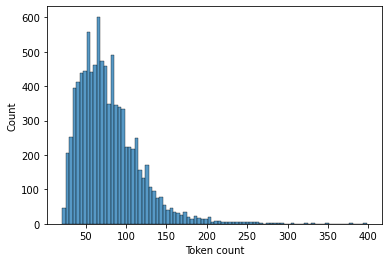


data type: validation
min length = 23 tokens
mean length = 77.73840769903762 tokens
max length = 254 tokens
4 texts longer than 212 tokens (0.003499562554680665)


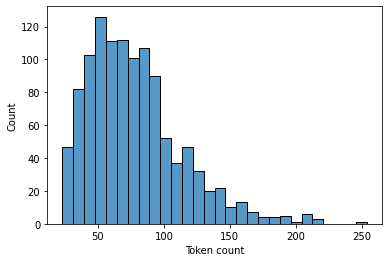


data type: test
min length = 21 tokens
mean length = 77.85034013605443 tokens
max length = 359 tokens
7 texts longer than 212 tokens (0.006802721088435374)


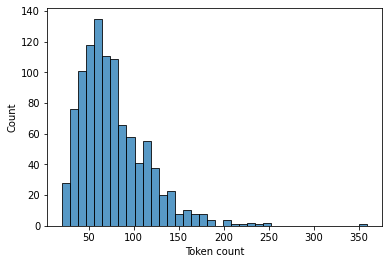


define max_len = 212


In [ ]:
max_len = define_max_len(df_train, df_val, df_test, tokenizer, max_len)

In [ ]:
# max_len = 312

In [ ]:
from razdel import tokenize, sentenize
def get_token_len(texts):
    token_lens = []
    # for txt in df.sentence:
    for txt in texts:
        token_lens.append(len(list(sentenize(txt))))
    return token_lens

In [ ]:
def token_len(token_lens):
    print(f'min length = {min(token_lens)} sentences')
    print(f'mean length = {mean(token_lens)} sentences')
    print(f'max length = {max(token_lens)} sentences')
    fig = sns.histplot(token_lens)
    plt.xlim((0, 20))
    plt.xticks(list(range(21)))
    plt.xlabel('Sentence count')
    plt.show()

min length = 3 sentences
mean length = 3.9148384307792066 sentences
max length = 6 sentences


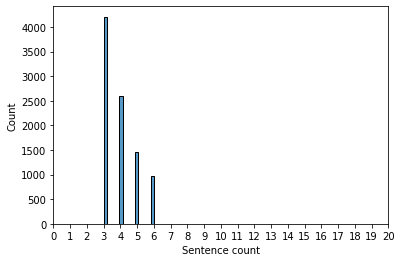

In [ ]:
token_len(get_token_len(list(df_train['text'])))

min length = 3 sentences
mean length = 3.925634295713036 sentences
max length = 6 sentences


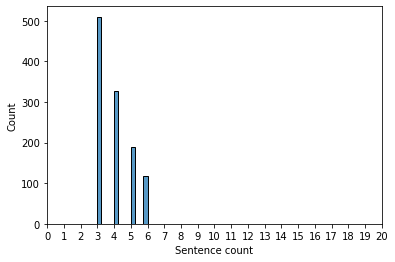

In [ ]:
token_len(get_token_len(list(df_val['text'])))

min length = 3 sentences
mean length = 3.891156462585034 sentences
max length = 6 sentences


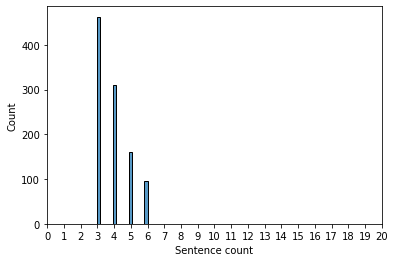

In [ ]:
token_len(get_token_len(list(df_test['text'])))

Александр Коваленко TRAIN
min length = 3 sentences
mean length = 3.6018368449486764 sentences
max length = 6 sentences


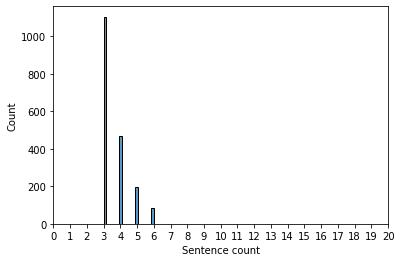

Александр Коваленко VALIDATION
min length = 3 sentences
mean length = 3.6812227074235806 sentences
max length = 6 sentences


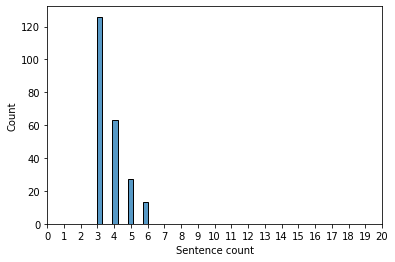

Александр Коваленко TEST
min length = 3 sentences
mean length = 3.5609756097560976 sentences
max length = 6 sentences


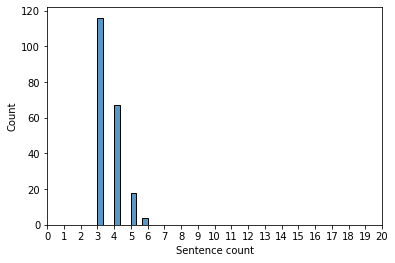

Александр Проханов TRAIN
min length = 3 sentences
mean length = 4.237709346299297 sentences
max length = 6 sentences


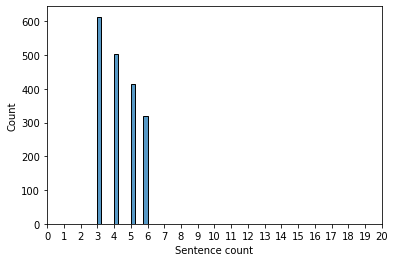

Александр Проханов VALIDATION
min length = 3 sentences
mean length = 4.258771929824562 sentences
max length = 6 sentences


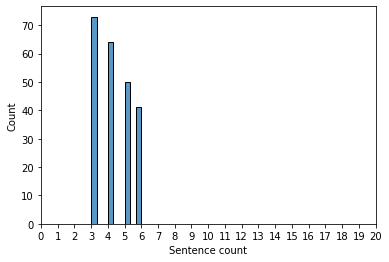

Александр Проханов TEST
min length = 3 sentences
mean length = 4.237864077669903 sentences
max length = 6 sentences


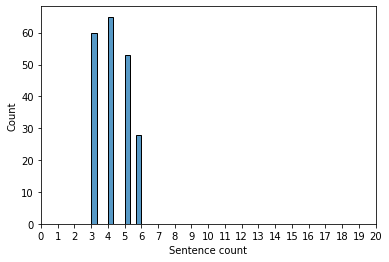

Артемий Лебедев TRAIN
min length = 3 sentences
mean length = 3.8605405405405406 sentences
max length = 6 sentences


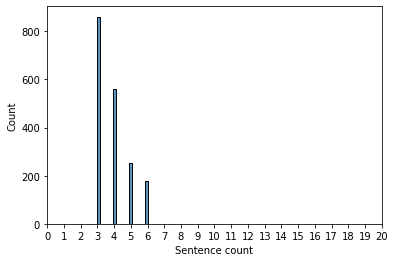

Артемий Лебедев VALIDATION
min length = 3 sentences
mean length = 4.0174672489082965 sentences
max length = 6 sentences


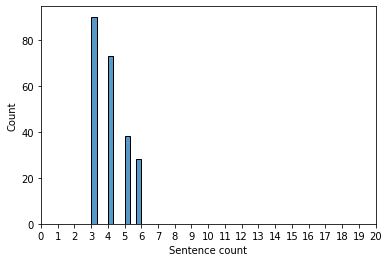

Артемий Лебедев TEST
min length = 3 sentences
mean length = 3.825242718446602 sentences
max length = 6 sentences


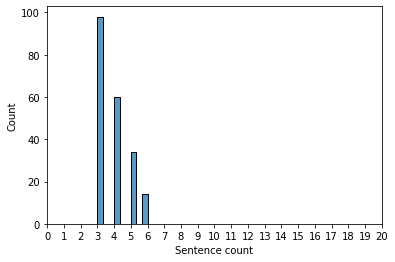

Дмитрий Пучков TRAIN
min length = 3 sentences
mean length = 3.845945945945946 sentences
max length = 6 sentences


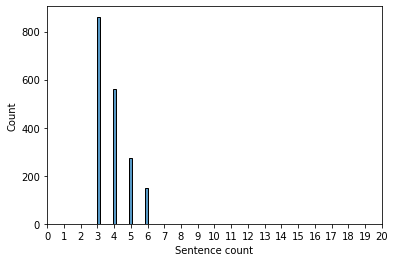

Дмитрий Пучков VALIDATION
min length = 3 sentences
mean length = 3.7860262008733625 sentences
max length = 6 sentences


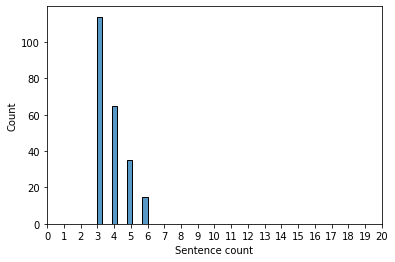

Дмитрий Пучков TEST
min length = 3 sentences
mean length = 3.8446601941747574 sentences
max length = 6 sentences


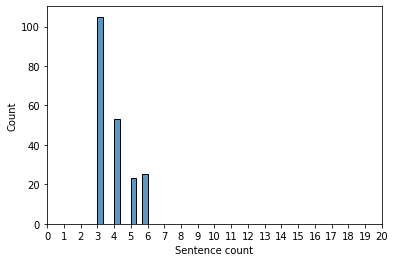

Федор Достоевский TRAIN
min length = 3 sentences
mean length = 4.028092922744462 sentences
max length = 6 sentences


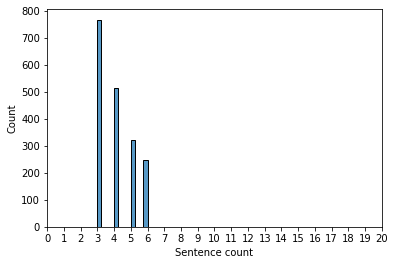

Федор Достоевский VALIDATION
min length = 3 sentences
mean length = 3.8859649122807016 sentences
max length = 6 sentences


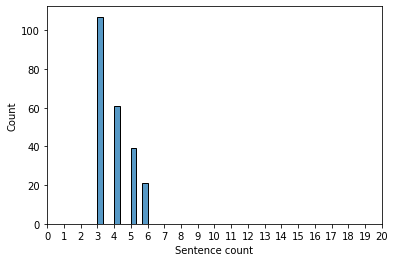

Федор Достоевский TEST
min length = 3 sentences
mean length = 3.9854368932038833 sentences
max length = 6 sentences


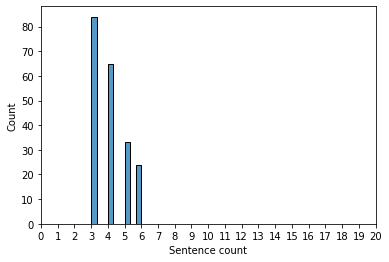

In [ ]:
for group_train, group_val, group_test  in zip(df_train.groupby('author'), df_val.groupby('author'),df_test.groupby('author')):
    print(group_train[0], "TRAIN")
    token_len(get_token_len(list(group_train[1]['text'])))
    print(group_val[0], "VALIDATION")
    token_len(get_token_len(list(group_val[1]['text'])))
    print(group_test[0], "TEST")
    token_len(get_token_len(list(group_test[1]['text'])))

# Подготовка данных

In [10]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

print(f'train_dataset:\n\n{train_dataset}')

train_dataset:

Dataset({
    features: ['text', 'author', 'label'],
    num_rows: 9253
})


In [11]:
def tokenize(batch):
    return tokenizer(
        batch['text'],
        max_length=max_len,
        padding='max_length',   
        truncation='longest_first'
    )

In [12]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_dataset = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

Map:   0%|          | 0/9253 [00:00<?, ? examples/s]

Map:   0%|          | 0/1143 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [13]:
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [14]:
test_dataset[0]

{'label': tensor(4),
 'input_ids': tensor([   101,    179, 110183,    121,    672,    129,   8151,   3069,    818,
          11065,    177,   2617,   1671,   9590,   2053,   1806,    834,    161,
           2617,    133,   2103,   3656,    152,   5918, 112192,    152,    161,
           1177,    121,   2625,   3662,   3948,    194,    789,    107,   5114,
            849,   1024,    199,    789,    107,  29613,    669,    119,    199,
           2704,    849,   1024,   4396,    126,   1081,   9590,    121,    696,
            113,  13448,    885,    121,    107,   1308,   2555,  60515,    107,
          10260,   6944,    179,   1418,   3980,  50148,    121,    725,   5714,
            199,    119,    700,   1721,    672, 118527,    121,   1025,    113,
          20685,    378,   6892,  54896,    121,  33610,    119,  18286,    126,
            818,    785,   1671,   4070,   9590,    113,  13448,    885,    107,
           2555,  60515,    121,   1747,    693,    725,  68625,    121,   

# Загрузка модели и обучение

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=num_author)

Some weights of the model checkpoint at ai-forever/ruBert-large were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not in

In [16]:
def compute_metrics(pred):
    '''Функция возвращает метрики качества'''
    labels = pred.label_ids
    preds = [p.argmax() for p in pred.predictions]
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_mean': np.mean(f1),
        'f1': f1.tolist(),
        'precision': precision.tolist(),
        'recall': recall.tolist()
    }

In [17]:
training_args = TrainingArguments(
    output_dir=output_dir,         
    overwrite_output_dir=overwrite_output_dir,   
    save_strategy=save_strategy,                
    num_train_epochs=num_train_epochs,            
    per_device_train_batch_size=per_device_train_batch_size,  
    per_device_eval_batch_size=64,  
    weight_decay=weight_decay,              
    learning_rate=learning_rate,              
    logging_dir=logging_dir,          
    evaluation_strategy=evaluation_strategy
)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

In [19]:
trainer.train_dataset = train_dataset
trainer.eval_dataset = val_dataset

In [ ]:
start_time = time()

trainer.train()

print(f'Time: {time() - start_time:.1f} sec')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Тестирование

In [ ]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='results_roberta/checkpoint-388', num_labels=num_author)
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics
)

loading configuration file results_roberta/checkpoint-388/config.json
Model config RobertaConfig {
  "_name_or_path": "results_roberta/checkpoint-388",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": 

In [ ]:
start_time = time()

test_predict_results = trainer.predict(test_dataset)

print(f'predictions:\n{test_predict_results.predictions}')
print(f'\n(true) label_ids:\n{test_predict_results.label_ids}')
print(f'\nmetrics:')
for key, value in test_predict_results.metrics.items():
    print(f'"{key}": {value}')
print(f'\nmacro f1: {np.mean(test_predict_results.metrics["test_f1"])}')

print(f'\nTime: {time() - start_time:.1f} sec')

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: author, text. If author, text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1029
  Batch size = 24
/opt/miniconda3/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


predictions:
[[-1.632793   -1.6282183  -1.4097149  -1.9110454   6.202854  ]
 [-1.9096037   6.878288   -0.69049907 -1.6907395  -1.4094412 ]
 [-0.94560707 -1.932257    6.204959   -1.2594068  -1.725396  ]
 ...
 [-2.8559282  -0.6152885   4.9673896   1.7478945  -2.5723386 ]
 [ 5.4565806  -2.427247   -1.872863   -0.14586695 -1.729013  ]
 [-0.37191793 -0.89091605 -1.6179554   5.19429    -2.3915892 ]]

(true) label_ids:
[4 1 2 ... 2 3 3]

metrics:
"test_loss": 0.2127411961555481
"test_accuracy": 0.9397473275024295
"test_f1_mean": 0.9399172275504603
"test_f1": [0.9343065693430658, 0.975609756097561, 0.9353233830845772, 0.863961813842482, 0.9903846153846153]
"test_precision": [0.9320388349514563, 0.9803921568627451, 0.9591836734693877, 0.8497652582159625, 0.9809523809523809]
"test_recall": [0.9365853658536586, 0.970873786407767, 0.912621359223301, 0.8786407766990292, 1.0]
"test_runtime": 10.6085
"test_samples_per_second": 96.997
"test_steps_per_second": 4.053

macro f1: 0.9399172275504603

Time:

In [ ]:
t_np = test_dataset['label'].numpy() #convert to Numpy array
df = pd.DataFrame(t_np) #convert to a dataframe
df.to_csv("test_labels.csv",index=False) #save to file

In [ ]:
test_pred = [np.argmax(a) for a in test_predict_results.predictions]

In [ ]:
df = pd.DataFrame(test_pred) #convert to a dataframe
df.to_csv("predictions.csv",index=False) #save to file

In [ ]:
print(classification_report(test_dataset['label'], test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9320    0.9366    0.9343       205
           1     0.9804    0.9709    0.9756       206
           2     0.9592    0.9126    0.9353       206
           3     0.8498    0.8786    0.8640       206
           4     0.9810    1.0000    0.9904       206

    accuracy                         0.9397      1029
   macro avg     0.9405    0.9397    0.9399      1029
weighted avg     0.9405    0.9397    0.9399      1029



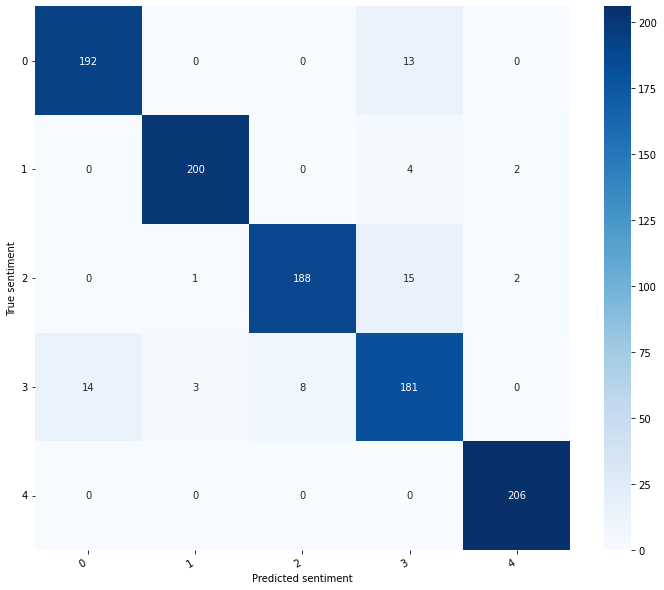

In [ ]:
def show_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(12,10)) 
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_dataset['label'], test_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)

__Results for 11 authors__

In [ ]:
print(classification_report(test_dataset['label'], test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8776    0.8034    0.8389       473
           1     0.7941    0.8562    0.8240       473
           2     0.7070    0.6786    0.6926       473
           3     0.8079    0.7378    0.7713       473
           4     0.6590    0.6102    0.6337       472
           5     0.8844    0.8414    0.8624       473
           6     0.7034    0.8224    0.7583       473
           7     0.8376    0.7526    0.7929       473
           8     0.8891    0.8816    0.8854       473
           9     0.7878    0.8478    0.8167       473
          10     0.7623    0.8541    0.8056       473

    accuracy                         0.7897      5202
   macro avg     0.7919    0.7897    0.7892      5202
weighted avg     0.7919    0.7897    0.7893      5202



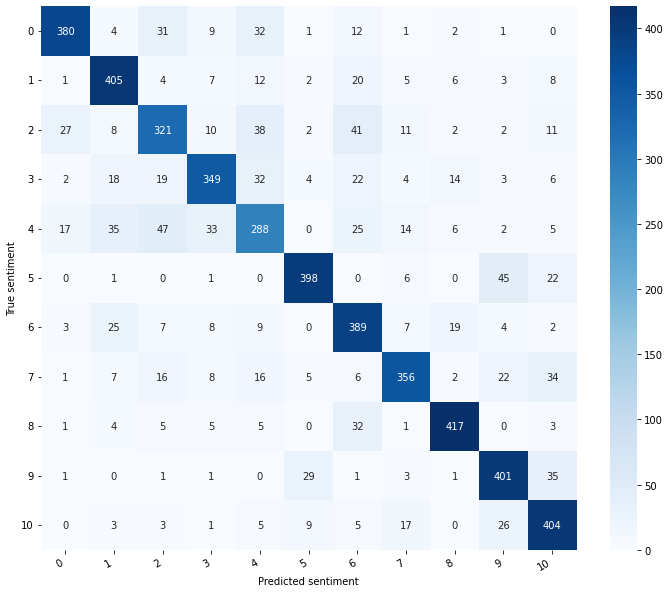

In [ ]:
def show_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(12,10)) 
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_dataset['label'], test_pred)
df_cm = pd.DataFrame(cm)
show_confusion_matrix(df_cm)